# TP3

Elaborado por: Alan Churichi

In [1]:
%load_ext lab_black

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en `Material_TPs/TP3/images` a partir del template `Material_TPs/TP3/template`.

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
   
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2.
   
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

Lo primero es cargar las imágenes a procesar. Las mismas se encuentran en `assets/images`.

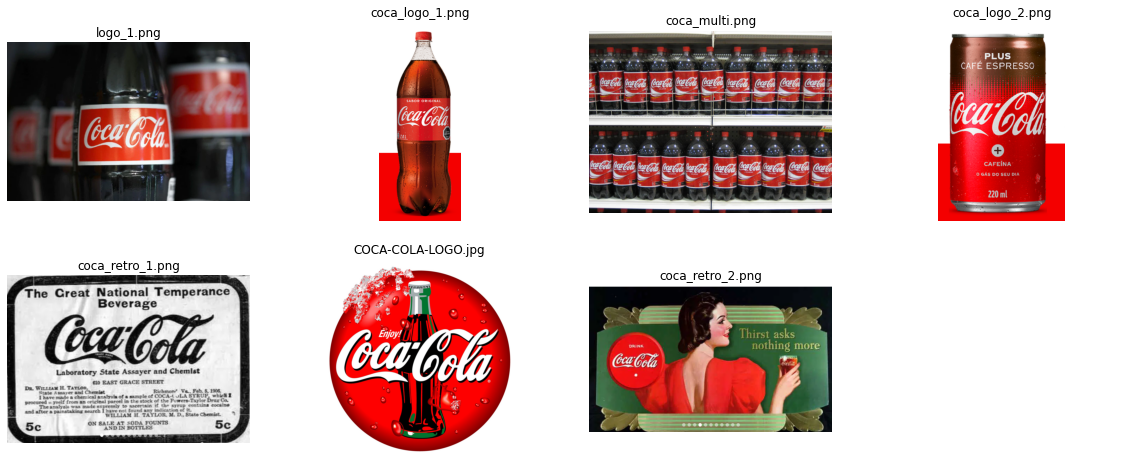

In [2]:
def load_image(path, filename, grayscale=False):
    flags = {"flags": cv.IMREAD_GRAYSCALE} if grayscale else {}
    img = cv.imread(os.path.join(path, filename), **flags)
    if grayscale:
        return img
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)


base_path = "/tf/notebooks/CEIA/computer-vision-1/tp3/assets"
images_path = os.path.join(base_path, "images")

filenames = os.listdir(images_path)
images = [load_image(images_path, filename) for filename in filenames]

_, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(2):
    for j in range(4):
        idx = i * 4 + j
        if idx < 7:
            axes[i][j].imshow(images[idx])
            axes[i][j].title.set_text(filenames[idx])
        axes[i][j].axis("off")

Cargamos el template que utilizaremos. Este se encuentran en `assets/template`.

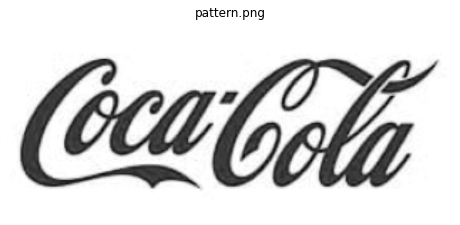

In [3]:
template_path = os.path.join(base_path, "template")

template = load_image(template_path, "pattern.png", grayscale=True)

plt.figure(figsize=(8, 8))
plt.imshow(template, cmap="gray")
plt.axis("off")
plt.title("pattern.png")
plt.show()

Para hacer match-template se necesita redimensionar el template. Se podría utilizar las funciones `cv.pyrUp()` y `cv.pyrDown()` pero estas solo duplican el tamaño o lo dividen por dos. Creamos una función personalizada `generate_pyramid()` para reesacalar el template a cualquier tamaño.

La función toma los siguientes argumentos:

- `img`: La imagen a redimensionar.
- `min_scale`: El tamaño mínimo del escalado.
- `max_scale`: El tamaño máximo de escalado.
- `steps`: La cantidad de niveles que tendrá la piramide. Incluyendo la imagen origianl.

In [4]:
def generate_pyramid(img, min_scale=0.1, max_scale=10, steps=10):
    pyramid = []

    if min_scale <= 0 or max_scale <= 0 or min_scale >= max_scale:
        raise Exception("Invalid values")
    if max_scale > 1 and min_scale < 1:
        scale_down = np.linspace(min_scale, 1, steps // 2, endpoint=False)
        scale_up = np.linspace(
            1, max_scale, steps // 2 + 1 if steps % 2 else steps // 2
        )
        scales = np.concatenate((scale_down, scale_up))
    else:
        scales = np.linspace(min_scale, max_scale, steps)
    scales
    (h, w) = img.shape

    for scale in scales:
        if scale == 1:
            pyramid.append(img)
        else:
            pyramid.append(
                cv.resize(
                    img,
                    (round(w * scale), round(h * scale)),
                    interpolation=cv.INTER_AREA if scale < 1 else cv.INTER_CUBIC,
                )
            )

    return pyramid

Generamos varios ejemplos.

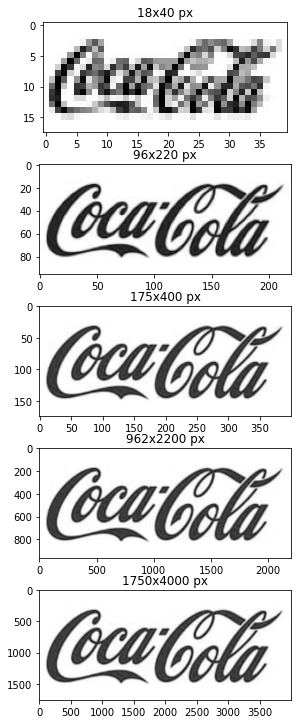

In [5]:
pyramid = generate_pyramid(template, 0.1, 10, 5)

_, axes = plt.subplots(len(pyramid), figsize=(10, 10))
plt.tight_layout()
for i in range(len(pyramid)):
    img = pyramid[i]
    axes[i].imshow(img, cmap="gray")
    axes[i].title.set_text(f"{img.shape[0]}x{img.shape[1]} px")

Creamos una función para hacer match-template. Esta función puede devolver una sola o varias detecciones dependiendo de los argumentos provistos.

La función recibe los siguientes parámetros:

- `img`: La imagen a procesar.
- `tempalte`: la iamgen a utilizar como template.
- `min_scale`: El factor mínimo de escalado para el template. Utilizado por `generate_pyramid()`.
- `max_scale`: El factor máximo de escalado para el template. Utilizado por `generate_pyramid()`.
- `steps`: La cantidad de niveles que tendrá la piramide. Incluyendo la imagen origianl. Utilizado por `generate_pyramid()`.
- `threshold`: Valor de threshold para la detección de múltiples imágenes. Si es `None` se devuelve solamente la detección con mayor score.
- `method`: Método que utilizará la función `cv.matchTemplate()` para generar el template.

En la función se ingresa el template y se generan pirmaides con tantos niveles como se haya especificado en el parámetro `steps`. Además, para mejorar el rendimiento del algoritmo, se genera otra piramide con los colores del invertidos. Se unen todas los templates distintos en un único vector y se comparan con la imagen de entrada en escala de grises. De todos los resultados posibles obtenidos se elige el de mayor score o todos los que superen el valor de `threshold` si el parámetro fue seteado. Finalmente se devuelve un array con el o los resultados.

In [6]:
def match_template(
    img,
    template,
    min_scale=0.1,
    max_scale=10,
    steps=10,
    threshold=None,
    method=cv.TM_CCOEFF_NORMED,
):
    template_inv = cv.bitwise_not(template)
    template_pyramid = [
        *generate_pyramid(template, min_scale, max_scale, steps),
        *generate_pyramid(template_inv, min_scale, max_scale, steps),
    ]

    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    results = []
    for template_scaled in template_pyramid:
        try:
            res = cv.matchTemplate(img_gray, template_scaled, method)
            h, w = template_scaled.shape

            if threshold:
                loc = np.where(res >= threshold)
                relevant_detections = []
                for pt in zip(*loc[::-1]):
                    x, y = pt
                    relevant_detections.append((res[y, x], x, y, w, h))
                results.append(relevant_detections)
            else:
                _, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                x, y = (
                    min_loc
                    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
                    else max_loc
                )
                results.append([(max_val, x, y, w, h)])
        except:
            results.append([(0, 0, 0, 0, 0)])

    return max(results, key=lambda res: sum(item[0] for item in res))

Para poder probar nuestra funcion de forma sencilla definimos `match_template_plot`, que llama a la función `match_template`, obtiene los resutlados de la deteccion dibuja rectángulos con su score en las areas de interes y muestra la imagen procesada. 

In [7]:
GREEN_COLOR = (0, 255, 0)


def match_template_plot(
    img,
    template,
    min_scale=0.1,
    max_scale=10,
    steps=10,
    threshold=None,
    method=cv.TM_CCOEFF_NORMED,
    title="",
):
    results = match_template(
        img, template, min_scale, max_scale, steps, threshold, method
    )
    img_rgb = img.copy()

    if len(results) == 1:
        print(f"Score: {results[0][0]:.4f}")
    else:
        print(f"Scores: {[res[0] for res in results]}")

    for score, x, y, w, h in results:
        cv.rectangle(img_rgb, (x, y), (x + w, y + h), GREEN_COLOR, 3)
        cv.putText(
            img_rgb,
            f"{score:.4f}",
            (x, y - 10),
            cv.FONT_HERSHEY_SIMPLEX,
            0.9,
            GREEN_COLOR,
            2,
        )
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()

Utilizamos la función para detectar el logo en las diferentes imágenes.

Score: 0.4250


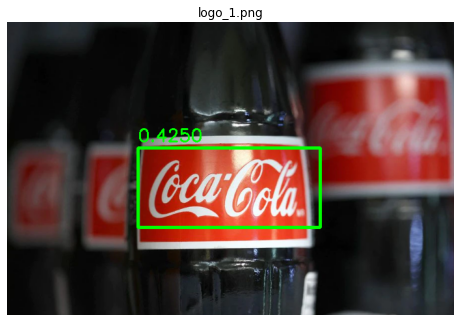

In [8]:
match_template_plot(
    images[0],
    template,
    min_scale=0.5,
    max_scale=2,
    steps=10,
    title=filenames[0],
)

Score: 0.3226


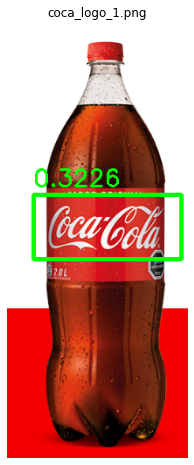

In [9]:
match_template_plot(
    images[1],
    template,
    min_scale=0.4,
    max_scale=0.6,
    steps=10,
    title=filenames[1],
)

Score: 0.5453


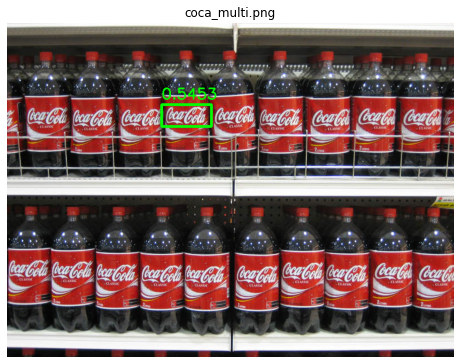

In [10]:
match_template_plot(
    images[2],
    template,
    min_scale=0.2,
    max_scale=0.4,
    steps=10,
    title=filenames[2],
)

Score: 0.3725


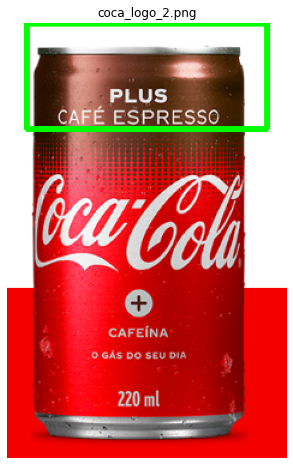

In [11]:
match_template_plot(
    images[3],
    template,
    min_scale=0.5,
    max_scale=1,
    steps=50,
    title=filenames[3],
)

En este caso se probó con distinta combinación de parámetros pero no se pudieron obtener buenos resultados.

Recortando los bordes de la imagen y probando distintos métodos se puede mejorar.

Score: 524262496.0000


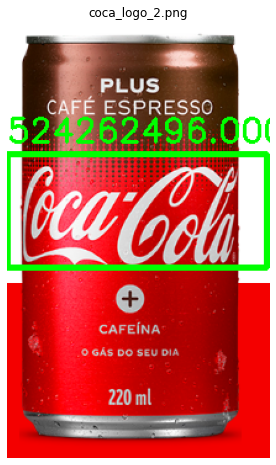

In [12]:
cropped_image = images[3].copy()[10:, 10:-10, :]

match_template_plot(
    cropped_image,
    template,
    min_scale=0.5,
    max_scale=1,
    steps=40,
    title=filenames[3],
    method=cv.TM_SQDIFF,
)

El logo se pudo detectar correctamente, sin embargo recortar la imagen a mano no es lo más óptimo. Se podría mejorar el algoritmo para que reconozca las partes importantes de la imagen y recorte los bordes automáticamente.

Score: 0.6864


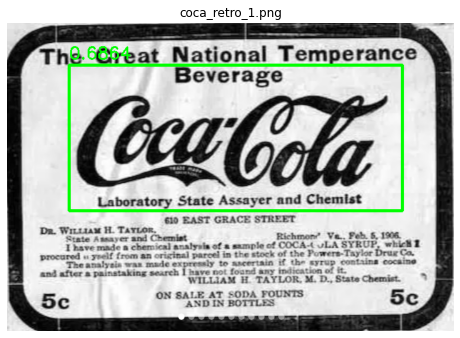

In [13]:
match_template_plot(
    images[4],
    template,
    min_scale=1,
    max_scale=2,
    steps=10,
    title=filenames[4],
)

Score: 0.5662


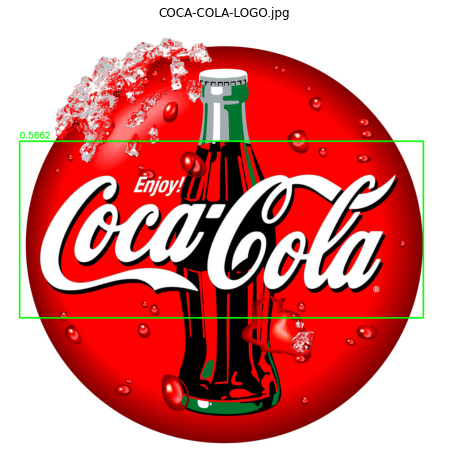

In [14]:
match_template_plot(
    images[5],
    template,
    min_scale=1,
    max_scale=5,
    steps=10,
    title=filenames[5],
)

Score: 0.6295


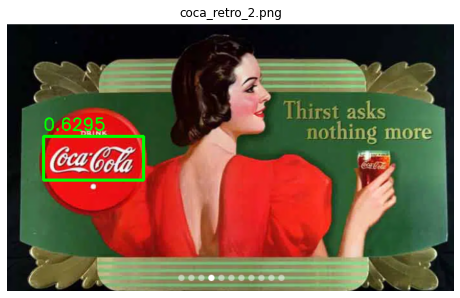

In [15]:
match_template_plot(
    images[6],
    template,
    min_scale=0.1,
    max_scale=1,
    steps=10,
    title=filenames[6],
)

Como vemos, en casi todos los casos se obtuvieron buenos resultados utilizando la funcion de match-template que creamos.

Procesamos nuevamente la imagen con con varias botellas de Coca-Cola y utilizamos el parámetro threshold en la función para obtener múltiples detecciones.

Scores: [0.54940677, 0.5358846, 0.5287621, 0.5091289, 0.51091576, 0.5816743, 0.50735134, 0.5054295, 0.55600226, 0.4865514, 0.48242143, 0.5130698, 0.49145535, 0.5338764, 0.49208143, 0.5716462, 0.5786711, 0.54763687, 0.55983824, 0.5287856, 0.5018116, 0.5402104, 0.48267233, 0.56255853, 0.5083368, 0.49196875, 0.56997544, 0.5331121, 0.48047456, 0.503415, 0.53949463, 0.5488225, 0.5149256, 0.49777797, 0.546462, 0.5663855, 0.4882012, 0.55693215, 0.5119241, 0.48935652, 0.48339266, 0.5510876, 0.55074286, 0.4991819, 0.57067406, 0.4956041, 0.5507376, 0.5460277, 0.48709697, 0.5300324, 0.49954125, 0.50576234, 0.5754317, 0.51381373, 0.52320915, 0.4891592, 0.5558712, 0.54313105, 0.51243246, 0.5480101, 0.48909473, 0.48510867, 0.55393445, 0.55596787, 0.5346632, 0.49499038]


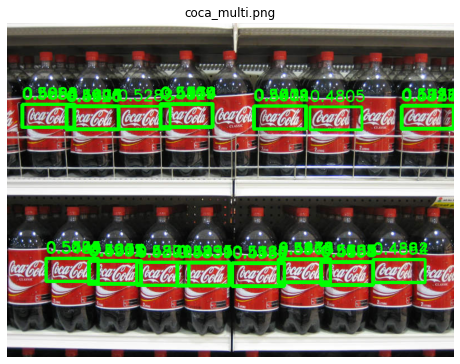

In [16]:
match_template_plot(
    images[2],
    template,
    min_scale=0.1,
    max_scale=0.5,
    steps=10,
    threshold=0.48,
    title=filenames[2],
)

Vemos que los resultados son muy buenos. Se pudieron detecar casi todas los logos en la imagen. Una posible mejora para el algoritmo podría ser eliminar múltiples detecciones sobre el mismo objeto. De esta forma evitamos tener detecciones repetidas en puntos muy cercanos.

### Conclusiones

El método implementado funciona muy bien para la deteccion de logos en imágenes, sin embargo requiere que se configuren los parámetros de manera manual para cada entrada a procesar.

Dos posibles mejoras a realizar serían las ya mencionadas, el recortado automático de bordes y la eliminación de detecciones duplicadas.

Se logró un único algoritmo capaz de realizar detecciones únicas y múltiples en las diferentes imágenes, por lo que se obtuvieron resultados satisfactorios para consignas 1, 2 y 3 del trabajo.